# 4.1 Final Models: Classification

In this notebook we look at the classification performance of our finalized GCN and GraphSAGE models:

- GCN/GraphSAGE Model
    - Final Parameters
    - Cross Validation
    - Final Training & Testing
    - Other Runs From Same Browser
    - Misclassifications

### Dataset Configuration

In [1]:
data_name = 'chrome-run-01'
with_centrality_metrics = False

### Set Up

In [2]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import torch
import torch.sparse
import os
import pandas as pd

In [4]:
import sys
models_path = os.path.join('..', 'src', 'models')
definitions_path = os.path.join('..', 'models', 'definitions')
data_path = os.path.join('..', 'src', 'data')
sys.path.append(models_path)
sys.path.append(definitions_path)
sys.path.append(data_path)
import train_model, evaluate_model
import gnn
import csv

We store the results from this notebook into different csv files:

In [6]:
models = ['gcn', 'variant']

for model in models:
    folder = os.path.join('..', 'results', model)
    if not os.path.exists(folder):
        os.makedirs(folder)

In [7]:
org_data_name = data_name

# Specify filename of the csv files to store the training logs and test results
csv_file_gcn = os.path.join('..', 'reports', 'gcn', 'final_model_log.csv')
csv_file_graphsage = os.path.join('..', 'reports', 'variant', 'final_model_log.csv')

cross_validate_gcn = os.path.join('..', 'results', 'gcn', 'cross_validation.csv')
cross_validate_graphsage = os.path.join('..', 'results', 'variant', 'cross_validation.csv')

test_results_gcn = os.path.join('..', 'results', 'gcn', 'classification.csv')
test_results_graphsage = os.path.join('..', 'results', 'variant', 'classification.csv')

metadata_path = os.path.join('..', 'data', 'processed', f'metadata-{org_data_name}.json')

We store the models from this notebook into the folder ```models```:

In [8]:
save_gcn = os.path.join('..', 'models', 'trained', 'gcn.pt')
save_graphsage = os.path.join('..', 'models', 'trained', 'graphsage.pt')

We load the dataset from the ````processed```` data file:

In [9]:
# Load the model and data
org_data_name = data_name
if with_centrality_metrics:
    data_name = f"{data_name}-with-centrality-metrics"
else:
    data_name = f"{data_name}-without-centrality-metrics"

data_folder = os.path.join('..', 'data', 'processed')
data_path = os.path.join(data_folder, f"{data_name}.pt")
data = torch.load(data_path)

We also load all other datasets from the same browser:

In [10]:
# Define configuration to load other datasets
data_parts = data_name.split("-")
run = data_parts[2]
current_browser = data_parts[0]
file_ending = '-with-centrality-metrics.pt' if with_centrality_metrics else '-without-centrality-metrics.pt'
files = files = os.listdir(data_folder)

# Construct the datasets list
runs = []

# Helper function to match the desired pattern
def is_other_run(file, browser, file_ending):
    return file.startswith(browser) and file.endswith(file_ending)

# Filter files based on the user's input and the specified ending
for file in files:
    if is_other_run(file, current_browser, file_ending):
        # Extract the name part before the ending
        name = file.split("-with", 1)[0]
        # Load the data using torch.load
        data_path = os.path.join(data_folder, file)
        data_set = torch.load(data_path)
        # Append the dictionary to the datasets list
        runs.append({'name': name, 'data': data_set})

print(f"All {current_browser.capitalize()} Runs:\n{runs}")

All Chrome Runs:
[{'name': 'chrome-run-01', 'data': Data(x=[25338, 33], edge_index=[2, 131846], num_nodes=25338, y=[25338], train_mask=[25338], val_mask=[25338], test_mask=[25338])}, {'name': 'chrome-run-02', 'data': Data(x=[25479, 33], edge_index=[2, 133278], num_nodes=25479, y=[25479], train_mask=[25479], val_mask=[25479], test_mask=[25479])}]


### GCN Model

#### Final Parameters

In [10]:
# Test results from grid search optimization
num_epochs = 1000
hidden_channels = 64
learning_rate = 0.0075
weight_decay = 5e-06
dropout_rate = 0.1

# Calculating class weights
labels = data.y[data.train_mask]
class_counts = labels.bincount()
class_weights = 1. / class_counts.float()
class_weights = class_weights / class_weights.sum()  # Normalize weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# Loss function
cross_entropy = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))

# GCN configurationGCN Model
final_gcn = [
    {'model_name': 'Final GCN', 'model': gnn.GCN_2_Layers, 'data_name': data_name, 'data': data, 'hidden_channels': hidden_channels, 'learning_rate': learning_rate, 'num_epochs': num_epochs, 'weight_decay': weight_decay, 'dropout_rate': dropout_rate, 'criterion': cross_entropy}
]

#### Cross Validation

In [11]:
evaluate_model.cross_validate(final_gcn, cross_validate_gcn, n_repeats=1)


Training Final GCN model (1/1) on chrome-run-01-without-centrality-metrics dataset...
Repetition: 1/1, Split: 1/10, Epoch: 50/500, Val Loss: 0.5977, Val Accuracy: 0.7584, Val Precision: 0.5840, Val Recall: 0.8533, Val F1: 0.6934
Repetition: 1/1, Split: 1/10, Epoch: 100/500, Val Loss: 0.5165, Val Accuracy: 0.7777, Val Precision: 0.6185, Val Recall: 0.7978, Val F1: 0.6968
Repetition: 1/1, Split: 1/10, Epoch: 150/500, Val Loss: 0.4819, Val Accuracy: 0.7848, Val Precision: 0.6327, Val Recall: 0.7818, Val F1: 0.6994
Repetition: 1/1, Split: 1/10, Epoch: 200/500, Val Loss: 0.4653, Val Accuracy: 0.7916, Val Precision: 0.6359, Val Recall: 0.8163, Val F1: 0.7149
Repetition: 1/1, Split: 1/10, Epoch: 250/500, Val Loss: 0.4485, Val Accuracy: 0.7927, Val Precision: 0.6331, Val Recall: 0.8385, Val F1: 0.7215
Repetition: 1/1, Split: 1/10, Epoch: 300/500, Val Loss: 0.4407, Val Accuracy: 0.8026, Val Precision: 0.6569, Val Recall: 0.8027, Val F1: 0.7225
Repetition: 1/1, Split: 1/10, Epoch: 350/500, Val 

#### Final Training & Testing

We train our model with the tuned parameters:


Training Final GCN model (1/1) on chrome-run-01-without-centrality-metrics dataset...
Run: 1/3, Model: Final GCN, Epoch: 50/1000, Loss: 0.8035, Val Loss: 0.5965, Val Accuracy: 0.7375, Val Precision: 0.5546, Val Recall: 0.9149, Val F1: 0.6906
Run: 1/3, Model: Final GCN, Epoch: 100/1000, Loss: 0.6019, Val Loss: 0.5521, Val Accuracy: 0.7442, Val Precision: 0.5643, Val Recall: 0.8816, Val F1: 0.6882
Run: 1/3, Model: Final GCN, Epoch: 150/1000, Loss: 0.5378, Val Loss: 0.5242, Val Accuracy: 0.7710, Val Precision: 0.6040, Val Recall: 0.8274, Val F1: 0.6982
Run: 1/3, Model: Final GCN, Epoch: 200/1000, Loss: 0.5086, Val Loss: 0.5101, Val Accuracy: 0.7793, Val Precision: 0.6180, Val Recall: 0.8138, Val F1: 0.7025
Run: 1/3, Model: Final GCN, Epoch: 250/1000, Loss: 0.4944, Val Loss: 0.5012, Val Accuracy: 0.7829, Val Precision: 0.6246, Val Recall: 0.8064, Val F1: 0.7040
Run: 1/3, Model: Final GCN, Epoch: 300/1000, Loss: 0.4852, Val Loss: 0.4951, Val Accuracy: 0.7852, Val Precision: 0.6305, Val Rec

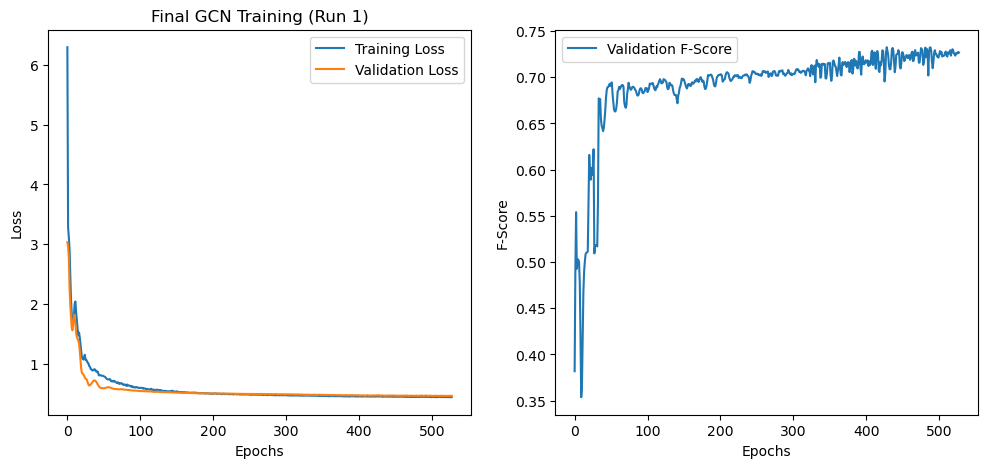

Run: 2/3, Model: Final GCN, Epoch: 50/1000, Loss: 0.6515, Val Loss: 0.5829, Val Accuracy: 0.7489, Val Precision: 0.5806, Val Recall: 0.7768, Val F1: 0.6646
Run: 2/3, Model: Final GCN, Epoch: 100/1000, Loss: 0.5489, Val Loss: 0.5323, Val Accuracy: 0.7722, Val Precision: 0.6066, Val Recall: 0.8212, Val F1: 0.6977
Run: 2/3, Model: Final GCN, Epoch: 150/1000, Loss: 0.5077, Val Loss: 0.5114, Val Accuracy: 0.7773, Val Precision: 0.6191, Val Recall: 0.7916, Val F1: 0.6948
Run: 2/3, Model: Final GCN, Epoch: 200/1000, Loss: 0.4849, Val Loss: 0.4975, Val Accuracy: 0.7860, Val Precision: 0.6341, Val Recall: 0.7842, Val F1: 0.7012
Run: 2/3, Model: Final GCN, Epoch: 250/1000, Loss: 0.4717, Val Loss: 0.4807, Val Accuracy: 0.7916, Val Precision: 0.6497, Val Recall: 0.7571, Val F1: 0.6993
Run: 2/3, Model: Final GCN, Epoch: 300/1000, Loss: 0.4604, Val Loss: 0.4733, Val Accuracy: 0.7939, Val Precision: 0.6470, Val Recall: 0.7842, Val F1: 0.7090
Run: 2/3, Model: Final GCN, Epoch: 350/1000, Loss: 0.4496, 

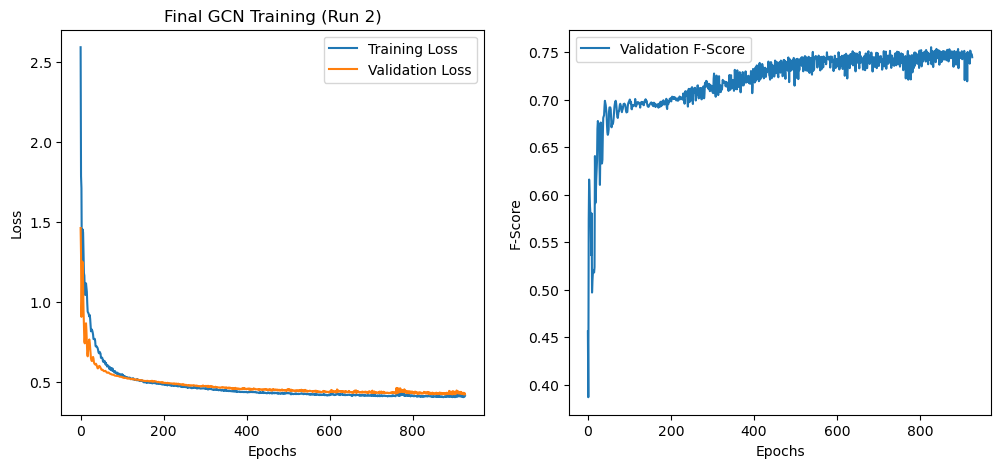

Run: 3/3, Model: Final GCN, Epoch: 50/1000, Loss: 0.6776, Val Loss: 0.5687, Val Accuracy: 0.7576, Val Precision: 0.5869, Val Recall: 0.8200, Val F1: 0.6842
Run: 3/3, Model: Final GCN, Epoch: 100/1000, Loss: 0.5424, Val Loss: 0.5205, Val Accuracy: 0.7623, Val Precision: 0.5902, Val Recall: 0.8434, Val F1: 0.6944
Run: 3/3, Model: Final GCN, Epoch: 150/1000, Loss: 0.5007, Val Loss: 0.4986, Val Accuracy: 0.7801, Val Precision: 0.6216, Val Recall: 0.8002, Val F1: 0.6997
Run: 3/3, Model: Final GCN, Epoch: 200/1000, Loss: 0.4826, Val Loss: 0.4889, Val Accuracy: 0.7876, Val Precision: 0.6347, Val Recall: 0.7928, Val F1: 0.7050
Run: 3/3, Model: Final GCN, Epoch: 250/1000, Loss: 0.4651, Val Loss: 0.4755, Val Accuracy: 0.7939, Val Precision: 0.6424, Val Recall: 0.8039, Val F1: 0.7141
Run: 3/3, Model: Final GCN, Epoch: 300/1000, Loss: 0.4567, Val Loss: 0.4701, Val Accuracy: 0.7975, Val Precision: 0.6367, Val Recall: 0.8557, Val F1: 0.7301
Run: 3/3, Model: Final GCN, Epoch: 350/1000, Loss: 0.4451, 

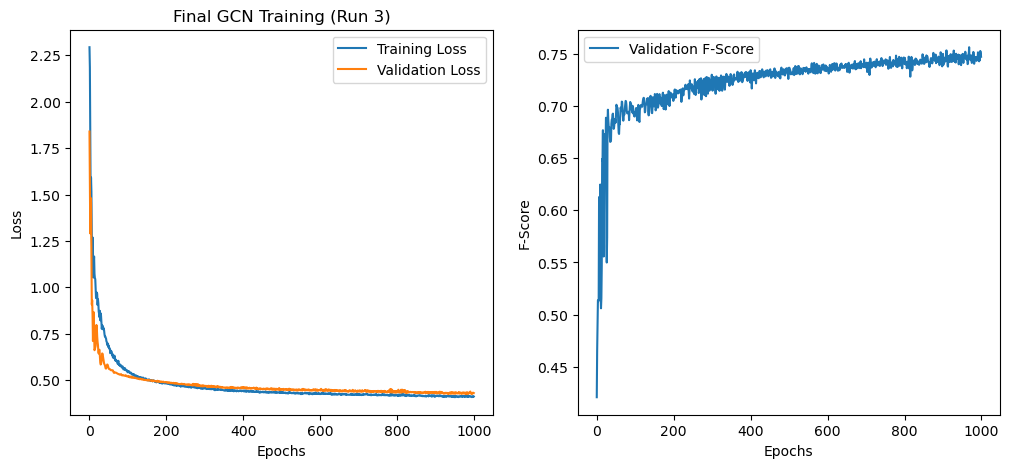

Successfully trained Final GCN model (1/1) on chrome-run-01-without-centrality-metrics dataset


In [12]:
trained_final_gcn = train_model.train_validate(final_gcn, csv_file_gcn, num_runs=3)
gcn = trained_final_gcn[0]['model']

Now, we can test the model performance:

In [13]:
test_accuracy, test_precision, test_recall, test_f1, _, _ = evaluate_model.test(data, gcn)

print(f"Test Accuracy: {test_accuracy}, Test Precision: {test_precision}, Test Recall: {test_recall}, Test F1: {test_f1}")

with open(test_results_gcn, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1'])
            writer.writerow([test_accuracy, test_precision, test_recall, test_f1])

Test Accuracy: 0.8337939202526649, Test Precision: 0.6976967370441459, Test Recall: 0.8727490996398559, Test F1: 0.7754666666666666


We save the trained model:

In [14]:
torch.save(gcn, save_gcn)

#### Other Runs From Same Browser

We use our models to classify the nodes of other web crawl runs of the same browser:

In [15]:
all_runs_gcn = os.path.join('..', 'results', 'gcn', 'all_runs_evaluation.csv')

evaluate_model.datasets_evaluate(runs, gcn, all_runs_gcn)


Evaluating GCN_2_Layers on different datasets...
Dataset: chrome-run-01, Accuracy: 0.8271, Precision: 0.6898, Recall: 0.8618, F1 Score: 0.7663
Dataset: chrome-run-02, Accuracy: 0.8291, Precision: 0.6931, Recall: 0.8637, F1 Score: 0.7690
Successfully evaluated GCN_2_Layers on different datasets


#### Misclassification

We save the misclassifed nodes in a csv file for further analysis:

In [15]:
gcn = torch.load(save_gcn)
misclassification_gcn = os.path.join('..', 'results', 'gcn', 'misclassifications.csv')

evaluate_model.misclassifications(data, gcn, metadata_path, misclassification_gcn)


Finding misclassified nodes...
Sucessfully found 4380 misclassified nodes and saved them into ..\results\gcn\misclassifications.csv


In [21]:
df = pd.read_csv(misclassification_gcn)

# Count the number of nodes with each true label
count_true_label_1 = df[df['True Label'] == 1].shape[0]
count_true_label_0 = df[df['True Label'] == 0].shape[0]

# Count number of nodes with specific words in them
count_cdn = df[df['Node'].str.contains('cdn')].shape[0]
keywords = ['ad', 'advert', 'popup', 'banner', 'sponsor', 'iframe', 'googlead', 'adsys', 'adser']
count_keywords = df['Node'].str.contains('|'.join(keywords), case=False).sum()

# Calculate the total number of entries
total_entries = df.shape[0]

# Calculate percentages 
percentage_label_1 = (count_true_label_1 / total_entries) * 100
percentage_label_0 = (count_true_label_0 / total_entries) * 100
percentage_cdn = (count_cdn / total_entries) * 100
percentage_keywords = (count_keywords / total_entries) * 100

# Print the counts and percentages
print("Number of nodes with True Label 1:", count_true_label_1, f"({percentage_label_1:.2f}%)")
print("Number of nodes with True Label 0:", count_true_label_0, f"({percentage_label_0:.2f}%)")
print("Number of nodes with \'cdn\' in name:", count_true_label_0, f"({percentage_cdn:.2f}%)")
print("Number of nodes with ad-related keywords in name:", count_keywords, f"({percentage_keywords:.2f}%)")

Number of nodes with True Label 1: 1151 (26.28%)
Number of nodes with True Label 0: 3229 (73.72%)
Number of nodes with 'cdn' in name: 3229 (12.49%)
Number of nodes with ad-related keywords in name: 407 (9.29%)


### GraphSAGE Model

#### Final Parameters

In [18]:
# Test results from Bayesian optimization
num_epochs = 1000
hidden_channels = 64
learning_rate = 0.0045350631649074685
weight_decay = 0.00042623544359182003
dropout_rate = 0.13495846416690738

# Calculating class weights
labels = data.y[data.train_mask]
class_counts = labels.bincount()
class_weights = 1. / class_counts.float()
class_weights = class_weights / class_weights.sum()  # Normalize weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# Loss function
cross_entropy = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))

# GraphSAGE configuration
final_graphsage = [
    {'model_name': 'Final GraphSAGE', 'model': gnn.GraphSAGE, 'data_name': data_name, 'data': data, 'hidden_channels': hidden_channels, 'learning_rate': learning_rate, 'num_epochs': num_epochs, 'weight_decay': weight_decay, 'dropout_rate': dropout_rate, 'criterion': cross_entropy}
]

#### Cross Validation

In [19]:
evaluate_model.cross_validate(final_graphsage, cross_validate_graphsage, n_repeats=1)


Training Final GraphSAGE model (1/1) on chrome-run-01-without-centrality-metrics dataset...
Repetition: 1/1, Split: 1/10, Epoch: 50/500, Val Loss: 0.3846, Val Accuracy: 0.8105, Val Precision: 0.6766, Val Recall: 0.7818, Val F1: 0.7254
Repetition: 1/1, Split: 1/10, Epoch: 100/500, Val Loss: 0.3284, Val Accuracy: 0.8148, Val Precision: 0.6516, Val Recall: 0.9063, Val F1: 0.7581
Repetition: 1/1, Split: 1/10, Epoch: 150/500, Val Loss: 0.3068, Val Accuracy: 0.8322, Val Precision: 0.6726, Val Recall: 0.9273, Val F1: 0.7797
Repetition: 1/1, Split: 1/10, Epoch: 200/500, Val Loss: 0.2953, Val Accuracy: 0.8413, Val Precision: 0.6874, Val Recall: 0.9248, Val F1: 0.7886
Repetition: 1/1, Split: 1/10, Epoch: 250/500, Val Loss: 0.2786, Val Accuracy: 0.8512, Val Precision: 0.7087, Val Recall: 0.9088, Val F1: 0.7963
Repetition: 1/1, Split: 1/10, Epoch: 300/500, Val Loss: 0.2750, Val Accuracy: 0.8484, Val Precision: 0.6953, Val Recall: 0.9371, Val F1: 0.7983
Repetition: 1/1, Split: 1/10, Epoch: 350/500

#### Final Training & Testing


Training Final GraphSAGE model (1/1) on chrome-run-01-without-centrality-metrics dataset...
Run: 1/3, Model: Final GraphSAGE, Epoch: 50/1000, Loss: 0.3821, Val Loss: 0.4125, Val Accuracy: 0.8030, Val Precision: 0.6605, Val Recall: 0.7916, Val F1: 0.7201
Run: 1/3, Model: Final GraphSAGE, Epoch: 100/1000, Loss: 0.3310, Val Loss: 0.3567, Val Accuracy: 0.8275, Val Precision: 0.6784, Val Recall: 0.8767, Val F1: 0.7649
Run: 1/3, Model: Final GraphSAGE, Epoch: 150/1000, Loss: 0.3032, Val Loss: 0.3321, Val Accuracy: 0.8496, Val Precision: 0.7194, Val Recall: 0.8693, Val F1: 0.7873
Run: 1/3, Model: Final GraphSAGE, Epoch: 200/1000, Loss: 0.2926, Val Loss: 0.2997, Val Accuracy: 0.8488, Val Precision: 0.7074, Val Recall: 0.9001, Val F1: 0.7922
Run: 1/3, Model: Final GraphSAGE, Epoch: 250/1000, Loss: 0.2949, Val Loss: 0.2976, Val Accuracy: 0.8287, Val Precision: 0.6673, Val Recall: 0.9273, Val F1: 0.7761
Run: 1/3, Model: Final GraphSAGE, Epoch: 300/1000, Loss: 0.2742, Val Loss: 0.2784, Val Accura

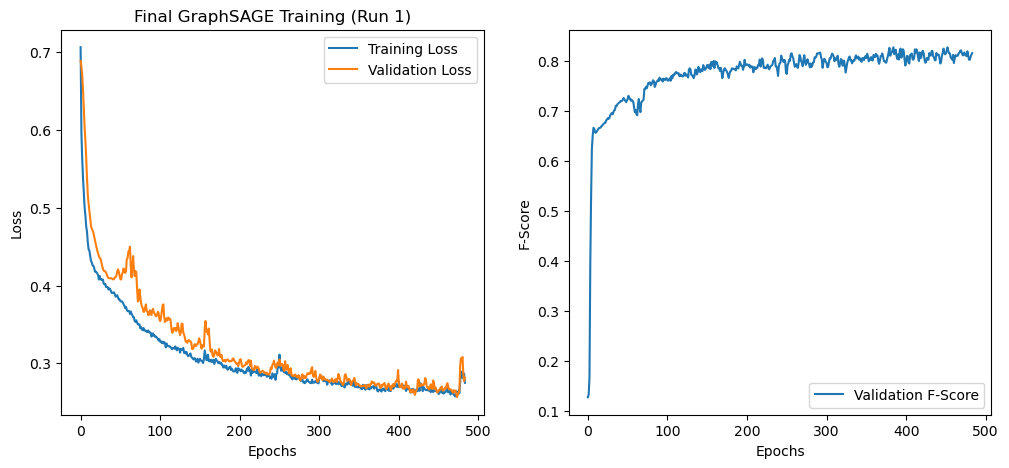

Run: 2/3, Model: Final GraphSAGE, Epoch: 50/1000, Loss: 0.3878, Val Loss: 0.4011, Val Accuracy: 0.7896, Val Precision: 0.6232, Val Recall: 0.8668, Val F1: 0.7251
Run: 2/3, Model: Final GraphSAGE, Epoch: 100/1000, Loss: 0.3371, Val Loss: 0.3837, Val Accuracy: 0.8318, Val Precision: 0.7090, Val Recall: 0.8052, Val F1: 0.7540
Run: 2/3, Model: Final GraphSAGE, Epoch: 150/1000, Loss: 0.3135, Val Loss: 0.3417, Val Accuracy: 0.8381, Val Precision: 0.6933, Val Recall: 0.8866, Val F1: 0.7781
Run: 2/3, Model: Final GraphSAGE, Epoch: 200/1000, Loss: 0.3041, Val Loss: 0.3108, Val Accuracy: 0.8310, Val Precision: 0.6693, Val Recall: 0.9334, Val F1: 0.7796
Run: 2/3, Model: Final GraphSAGE, Epoch: 250/1000, Loss: 0.2880, Val Loss: 0.3013, Val Accuracy: 0.8539, Val Precision: 0.7266, Val Recall: 0.8718, Val F1: 0.7926
Run: 2/3, Model: Final GraphSAGE, Epoch: 300/1000, Loss: 0.2799, Val Loss: 0.2946, Val Accuracy: 0.8306, Val Precision: 0.6670, Val Recall: 0.9408, Val F1: 0.7806
Run: 2/3, Model: Final 

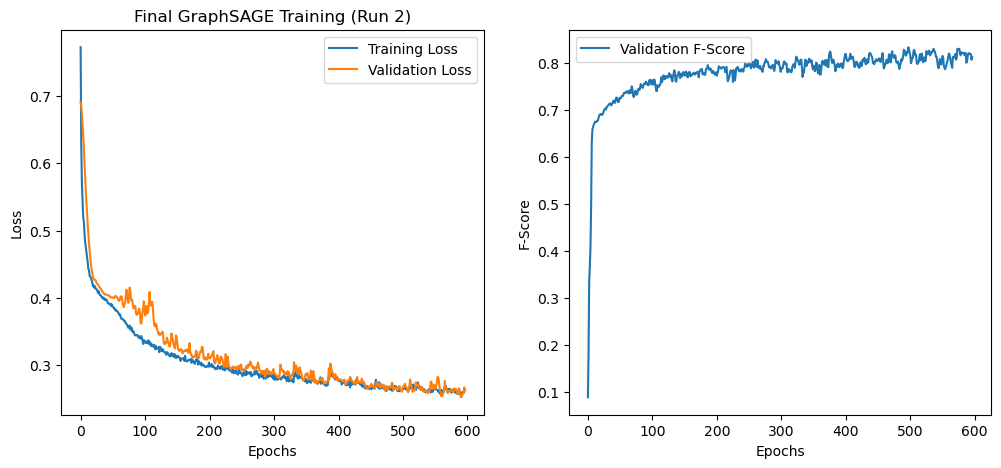

Run: 3/3, Model: Final GraphSAGE, Epoch: 50/1000, Loss: 0.3872, Val Loss: 0.4054, Val Accuracy: 0.7560, Val Precision: 0.5751, Val Recall: 0.9112, Val F1: 0.7052
Run: 3/3, Model: Final GraphSAGE, Epoch: 100/1000, Loss: 0.3320, Val Loss: 0.3582, Val Accuracy: 0.8038, Val Precision: 0.6342, Val Recall: 0.9149, Val F1: 0.7491
Run: 3/3, Model: Final GraphSAGE, Epoch: 150/1000, Loss: 0.3064, Val Loss: 0.3233, Val Accuracy: 0.8326, Val Precision: 0.6824, Val Recall: 0.8927, Val F1: 0.7735
Run: 3/3, Model: Final GraphSAGE, Epoch: 200/1000, Loss: 0.2952, Val Loss: 0.3018, Val Accuracy: 0.8460, Val Precision: 0.6958, Val Recall: 0.9223, Val F1: 0.7932
Run: 3/3, Model: Final GraphSAGE, Epoch: 250/1000, Loss: 0.2843, Val Loss: 0.2877, Val Accuracy: 0.8559, Val Precision: 0.7208, Val Recall: 0.8977, Val F1: 0.7996
Run: 3/3, Model: Final GraphSAGE, Epoch: 300/1000, Loss: 0.2782, Val Loss: 0.2817, Val Accuracy: 0.8448, Val Precision: 0.6957, Val Recall: 0.9162, Val F1: 0.7908
Run: 3/3, Model: Final 

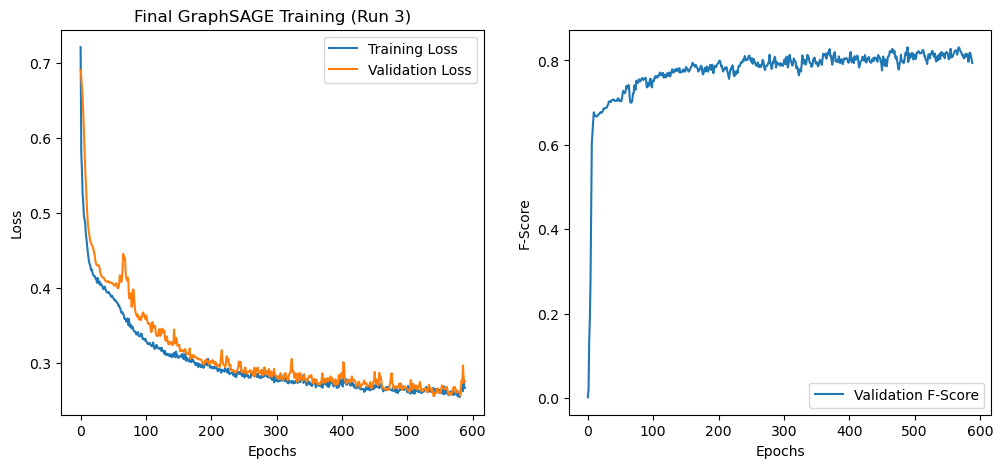

Successfully trained Final GraphSAGE model (1/1) on chrome-run-01-without-centrality-metrics dataset


In [20]:
trained_final_graphsage = train_model.train_validate(final_graphsage, csv_file_graphsage, num_runs=3)
graphsage = trained_final_graphsage[0]['model']

In [21]:
test_accuracy, test_precision, test_recall, test_f1, _, _ = evaluate_model.test(data, graphsage)

print(f"Test Accuracy: {test_accuracy}, Test Precision: {test_precision}, Test Recall: {test_recall}, Test F1: {test_f1}")

with open(test_results_graphsage, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1'])
            writer.writerow([test_accuracy, test_precision, test_recall, test_f1])

Test Accuracy: 0.8586656138965654, Test Precision: 0.7205199628597957, Test Recall: 0.9315726290516206, Test F1: 0.812565445026178


We can now save the trained model:

In [22]:
torch.save(graphsage, save_graphsage)

#### Other Runs From Same Browser

In [23]:
graphsage = torch.load(save_graphsage)

all_runs_graphsage = os.path.join('..', 'results', 'variant', 'all_runs_evaluation.csv')

evaluate_model.datasets_evaluate(runs, graphsage, all_runs_graphsage)


Evaluating GraphSAGE on different datasets...
Dataset: chrome-run-01, Accuracy: 0.8652, Precision: 0.7290, Recall: 0.9390, F1 Score: 0.8208
Dataset: chrome-run-02, Accuracy: 0.8641, Precision: 0.7290, Recall: 0.9352, F1 Score: 0.8193
Successfully evaluated GraphSAGE on different datasets


#### Misclassification

In [24]:
graphsage = torch.load(save_graphsage)

misclassification_graphsage = os.path.join('..', 'results', 'variant', 'misclassifications.csv')

evaluate_model.misclassifications(data, graphsage, metadata_path, misclassification_graphsage)


Finding misclassified nodes...
Sucessfully found 3416 misclassified nodes and saved them into ..\results\variant\misclassifications.csv


In [25]:
df = pd.read_csv(misclassification_graphsage)

# Count the number of nodes with each true label
count_true_label_1 = df[df['True Label'] == 1].shape[0]
count_true_label_0 = df[df['True Label'] == 0].shape[0]

# Calculate the total number of entries
total_entries = df.shape[0]

# Calculate percentages
percentage_label_1 = (count_true_label_1 / total_entries) * 100
percentage_label_0 = (count_true_label_0 / total_entries) * 100

# Print the counts and percentages
print("Number of nodes with True Label 1:", count_true_label_1, f"({percentage_label_1:.2f}%)")
print("Number of nodes with True Label 0:", count_true_label_0, f"({percentage_label_0:.2f}%)")

Number of nodes with True Label 1: 508 (14.87%)
Number of nodes with True Label 0: 2908 (85.13%)
